# analyze_metadata_table

This notebook builds on the previously produced data table, performs QC, and adds meta-features for visualization.

In [1]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

### Import data

In [2]:
# import table from create_metadata_table.ipynb
allFactors = pd.read_csv('../data_tables/metadataMatrix_raw.csv', low_memory=False)

### Conduct analysis on this table, producing new metrics

In [3]:
# add a column with the total use count of each converted_accession ID

# first, create a new dataframe with no double-counted accessions
# justAcc includes all unique pairings of PMC ID and Series/Study accession
justAcc = allFactors.loc[:, ['pmc_ID', 'converted_accession']]
justAcc = justAcc.drop_duplicates()

rc = Counter(justAcc['converted_accession'])
reuse_counts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
reuse_counts.columns = ['converted_accession', 'total_use_count']
# reuse_counts

In [4]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how = 'left', on = 'converted_accession')
# allFactors

In [5]:
# normalize reuse count by amount of time public

# convert repository upload dates and today's date to datetime objects
allFactors.loc[:,'repository_date'] = allFactors['repository_date'].replace({' ':''})
fmt = '%Y-%m-%d'
allFactors.loc[:,'repository_date'] = pd.to_datetime(allFactors['repository_date'], format = fmt)
allFactors['today'] = date.today().strftime(fmt)
allFactors['today'] = pd.to_datetime(allFactors['today'], format = fmt)

# create timedelta objects representing amount of time public in YEARS
allFactors['time_public'] = allFactors['today'] - allFactors['repository_date']
allFactors['time_public'] = allFactors['time_public'].dt.days / 365

# normalize reuse count by years public
allFactors['reuse_count'] = (allFactors['total_use_count'] - 1)
allFactors['norm_reuse_count'] = allFactors['reuse_count'] / allFactors['time_public']
allFactors = allFactors.drop(labels = ['total_use_count'], axis = 1)
# allFactors

In [6]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
justPap = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()
justPap = justPap.groupby('converted_accession', as_index = False).agg({'pmc_date': 'min'})
justPap = justPap.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
justPap.loc[:,'reuse_role'] = 'G'
# justPap

In [7]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(allFactors, justPap, how = 'left', 
                      left_on = ['converted_accession', 'pmc_date'], 
                      right_on = ['converted_accession', 'min_pmc_date'])

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors['allR'] = 'R'
allFactors['reuse_role'] = allFactors['reuse_role'].fillna(allFactors['allR'])

# drop redundant columns
allFactors = allFactors.drop(labels = ['min_pmc_date', 'allR'], axis = 1)

# allFactors

In [8]:
# perform QC on generator/reuser tags...

# cut out whitespace
allFactors.loc[:,'pmc_date'] = allFactors['pmc_date'].replace({' ':''})

# take slice of what we need from allFactors
# gens = allFactors[['pmc_ID', 'converted_accession', 'repository', 'pmc_date', 'repository_date', 'reuse_role']]
gens = allFactors.loc[allFactors['reuse_role'] == 'G', :]

# convert to date objects
fmt = '%Y-%m-%d'
gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = fmt)
gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = fmt)

# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']
gens = gens.dropna(subset = ['pub_delay'])

# convert timedeltas back to integers
gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days
gens = gens.sort_values(by = 'pub_delay', ascending = False)

# gens

# head = gens.head(n = 15)
# tail = gens.tail(n = 15)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


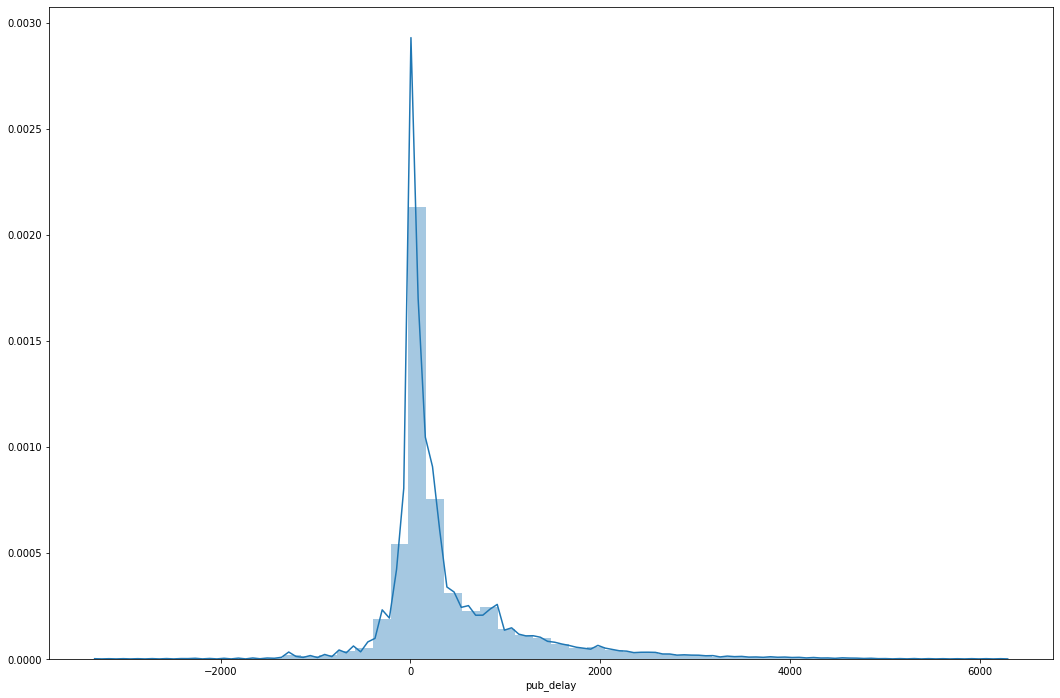

In [9]:
# plot timedelta distribution
fig_dims = (18,12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens['pub_delay'], ax = ax)

In [10]:
# select only papers in a reasonable timedelta window

DELAY_MIN = -270
DELAY_MAX = 270

gens_filtered = gens.loc[gens['pub_delay'] <= DELAY_MAX, :].loc[gens['pub_delay'] >= DELAY_MIN, :]
# gens_filtered

In [11]:
# select random papers inside/outside threshold for QC analysis
import random

# gens_filtered are inside threshold already
# get papers outside threshold, but within 365 days

DELAY_EDGE = 365

gens_aboveThresh = gens.loc[gens['pub_delay'] >= DELAY_MAX, :].loc[gens['pub_delay'] <= DELAY_EDGE]
gens_aboveThresh = gens_aboveThresh.loc[gens_aboveThresh['repository'] == "GEO", :]
gens_belowThresh = gens.loc[gens['pub_delay'] <= DELAY_MIN, :].loc[gens['pub_delay'] >= -DELAY_EDGE]
gens_belowThresh = gens_belowThresh.loc[gens_belowThresh['repository'] == "GEO", :]
gens_insideThresh = gens_filtered.loc[gens_filtered['repository'] == "GEO", :]

num_papers = 50
half_papers = int(num_papers / 2)

# take random samples inside, above, and below threshold
rand_in = pd.DataFrame(random.sample(gens_insideThresh['pmc_ID'].tolist(), num_papers))
rand_in.columns = ['pmc_ID']
rand_ab = pd.DataFrame(random.sample(gens_aboveThresh['pmc_ID'].tolist(), half_papers))
rand_ab.columns = ['pmc_ID']
rand_be = pd.DataFrame(random.sample(gens_belowThresh['pmc_ID'].tolist(), half_papers))
rand_be.columns = ['pmc_ID']

# match accessions to papers to make manual work easier
r_in = pd.merge(rand_in, gens_insideThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_in['real_introducer'] = np.NaN
r_ab = pd.merge(rand_ab, gens_aboveThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_be = pd.merge(rand_be, gens_belowThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_out = pd.concat([r_ab, r_be])
r_out['real_introducer'] = np.NaN

# save incomplete files to csv
r_in.to_csv('../data_tables/randomIntroducers_INSIDE.csv', index = False)
r_out.to_csv('../data_tables/randomIntroducers_OUTSIDE.csv', index = False)

In [12]:
# not included in the script: have someone else (very nicely) manually 
# validate each of these randomly selected paper-dataset relationships

# import the manually produced data (now complete files)
rinf = pd.read_csv("../data_tables/randomIntroducers_INSIDE_270days_filledin.csv").dropna()
routf = pd.read_csv("../data_tables/randomIntroducers_OUTSIDE_270days_filledin.csv").dropna()

# create a true positive column
# true positive means PMC_ID == REAL_INTRODUCER
rinf["TP"] = np.where(rinf["pmc_ID"] == rinf["real_introducer"], True, False)
routf["TN"] = np.where(routf["pmc_ID"] != routf["real_introducer"], True, False)

# reduce the tables to just PMC_ID and TP/TN
rinf = rinf[["pmc_ID", "TP"]].drop_duplicates()
routf = routf[["pmc_ID", "TN"]].drop_duplicates()

tp = statistics.mean(rinf["TP"])
tn = statistics.mean(routf["TN"])

print("True Positive rate (inside threshold): " + str(tp))
print("True Negative rate (outside threshold, inside year): " + str(tn))

True Positive rate (inside threshold): 0.9787234042553191
True Negative rate (outside threshold, inside year): 0.25


In [13]:
not_gens = allFactors.loc[allFactors['reuse_role'] != 'G', :]
filtered_matrix = pd.concat(objs = [gens_filtered, not_gens], ignore_index = True, sort = False)
# filtered_matrix

In [14]:
lsc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == "SRA", ]["library_strategy"])
lsc_df = pd.DataFrame.from_dict(lsc, orient = 'index').reset_index()
sraLS = list(lsc_df["index"])
# sraLS

In [15]:
# add a column for "class"... separating GEO/SRA distinction into:
# (1) GEO gene expression
# (2) RNA-seq (GEO and SRA)
# (3) SRA other omics technologies

key = {"repository": ["GEO", "GEO"] + ["SRA"]*(len(sraLS)), 
       "library_strategy": ["Expression_Array", "RNA-Seq"] + sraLS,
      "class": ["GEO_expr", "RNA-Seq", "RNA-Seq"] + ["SRA_other"]*(len(sraLS) - 1)}
key = pd.DataFrame(key)
# key

In [16]:
filtered_matrix = pd.merge(filtered_matrix, key, how = 'left', on = ['repository', 'library_strategy'])
filtered_matrix

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay,class
0,PLoS_Genet,PMC6161853,SRR5298268,SRP100898,SRA,2018-09-28 00:00:00,2018-01-01,Brachypodium distachyon,Illumina HiSeq 2500,WGS,202.0,1.438218e+10,public,2020-10-29,2.827397,0,0.000000,G,270.0,RNA-Seq
1,BMC_Genomics,PMC3561122,SRX145078,SRP009831,SRA,2013-01-23 00:00:00,2012-04-28,Anolis carolinensis,Illumina HiSeq 2000,RNA-Seq,152.0,2.956660e+08,public,2020-10-29,8.509589,3,0.352543,G,270.0,SRA_other
2,BMC_Genomics,PMC3561122,SRX112552,SRP009831,SRA,2013-01-23 00:00:00,2012-04-28,Anolis carolinensis,Illumina HiSeq 2000,RNA-Seq,152.0,2.956660e+08,public,2020-10-29,8.509589,3,0.352543,G,270.0,SRA_other
3,BMC_Genomics,PMC3561122,SRX112551,SRP009831,SRA,2013-01-23 00:00:00,2012-04-28,Anolis carolinensis,Illumina HiSeq 2000,RNA-Seq,152.0,2.956660e+08,public,2020-10-29,8.509589,3,0.352543,G,270.0,SRA_other
4,Front_Microbiol,PMC6411702,PRJNA474271,SRP150043,SRA,2019-03-05 00:00:00,2018-06-08,food fermentation metagenome,Illumina MiSeq,AMPLICON,483.0,3.779060e+08,public,2020-10-29,2.394521,0,0.000000,G,270.0,SRA_other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176482,Saudi_J_Biol_Sci,PMC5851940,GSM107072,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-10-29,14.424658,269,18.648623,R,NaN,GEO_expr
176483,Saudi_J_Biol_Sci,PMC5851940,GSM107231,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-10-29,14.424658,269,18.648623,R,NaN,GEO_expr
176484,Saudi_J_Biol_Sci,PMC6088103,GSE29378,GSE29378,GEO,2018-05-18,2013-06-07,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2020-10-29,7.400000,15,2.027027,R,NaN,GEO_expr
176485,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-10-29,9.252055,32,3.458691,R,NaN,GEO_expr


In [26]:
# what are the SRA library strategies?
lc = Counter(filtered_matrix.loc[filtered_matrix["repository"] == "SRA", :]["library_strategy"])
libCntr = pd.DataFrame.from_dict(lc, orient = "index")
libCntr.to_csv("../data_tables/SRAlibraryStrategies.csv", header = False)

In [17]:
# how much data coverage do we get when using the class column?
Counter(filtered_matrix['class'])

Counter({'RNA-Seq': 51796, 'SRA_other': 39916, 'GEO_expr': 54737, nan: 30038})

In [18]:
filtered_matrix.to_csv('../data_tables/metadataMatrix_filtered.csv', index = False)